# Rendering Demo
Rendering utilities for ContactPose are defined in [utilities/rendering.py](utilities/rendering.py). Rendering requires [pyrender](https://pyrender.readthedocs.io/en/latest/#), which offers headless rendering.

**First, follow the [pyrender setup instructions](docs/rendering.md).**

Basic imports.

In [1]:
# Copyright (c) Facebook, Inc. and its affiliates.
# Code by Samarth Brahmbhatt
%load_ext autoreload
%autoreload 2
%matplotlib notebook

from utilities.dataset import ContactPose
import utilities.misc as mutils
import utilities.rendering as rutils
import matplotlib.pyplot as plt
import cv2
import numpy as np

p_num, intent, object_name = 28, 'use', 'bowl'
cp = ContactPose(p_num, intent, object_name)

Function for creating the renderer objects.

In [2]:
def create_renderers(camera_name):
    # renderer for object mesh
    # note the mesh_scale, ContactPose object models are in units of mm 
    object_renderer = rutils.DepthRenderer(object_name, cp.K(camera_name), camera_name, mesh_scale=1e-3)

    # hand renderers
    hand_renderers = []
    for mesh in cp.mano_meshes():
        if mesh is None:  # this hand is not present for this grasp
            hand_renderers.append(None)
        else:
            renderer = rutils.DepthRenderer(mesh, cp.K(camera_name), camera_name)
            hand_renderers.append(renderer)
    return {'object': object_renderer, 'hands': hand_renderers}

Function for showing the rendering outputs.

In [3]:
def show_rendering_output(renderers, color_im, camera_name, frame_idx, crop_size=-1):
    joints = cp.projected_hand_joints(camera_name, frame_idx)
    if crop_size > 0:
        color_im, _ = mutils.crop_image(color_im, joints, crop_size)
    
    # object rendering
    object_rendering = renderers['object'].render(cp.object_pose(camera_name, frame_idx))
    if crop_size > 0:
        object_rendering, _ = mutils.crop_image(object_rendering, joints, crop_size)    
    object_mask = object_rendering > 0
    color_im[object_mask] = (0, 255, 255)  # yellow
    
    # hand rendering
    both_hands_rendering = []
    for renderer, mask_color in zip(renderers['hands'], ((0, 255, 0), (0, 0, 255))):
        if renderer is None:  # this hand is not present for this grasp
            continue
        # hand meshes are already in the object coordinate system, so we can use
        # object pose for rendering
        rendering = renderer.render(cp.object_pose(camera_name, frame_idx))
        if crop_size > 0:
            rendering, _ = mutils.crop_image(rendering, joints, crop_size)
        both_hands_rendering.append(rendering)
        mask = rendering > 0
        color_im[mask] = mask_color
    both_hands_rendering = np.dstack(both_hands_rendering).max(2)
    
    # show
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
    ax0.imshow(color_im[:, :, ::-1])
    ax0.set_title('Masks')
    ax1.imshow(object_rendering)
    ax1.set_title('Object Depth')
    ax2.imshow(both_hands_rendering)
    ax2.set_title('Hand Depth')
    fig.suptitle(camera_name)

Show outputs

<IPython.core.display.Javascript object>


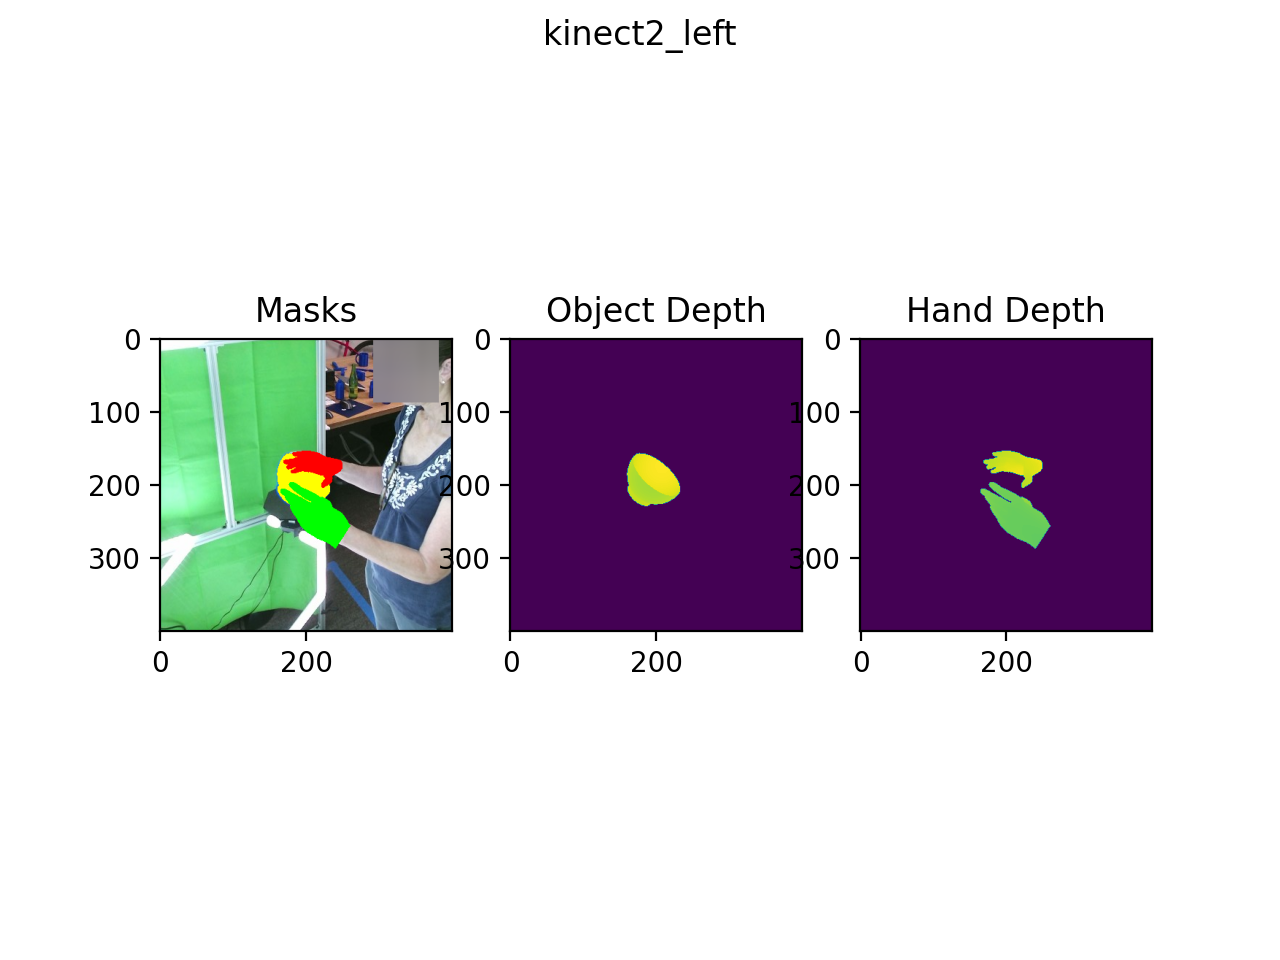

<IPython.core.display.Javascript object>


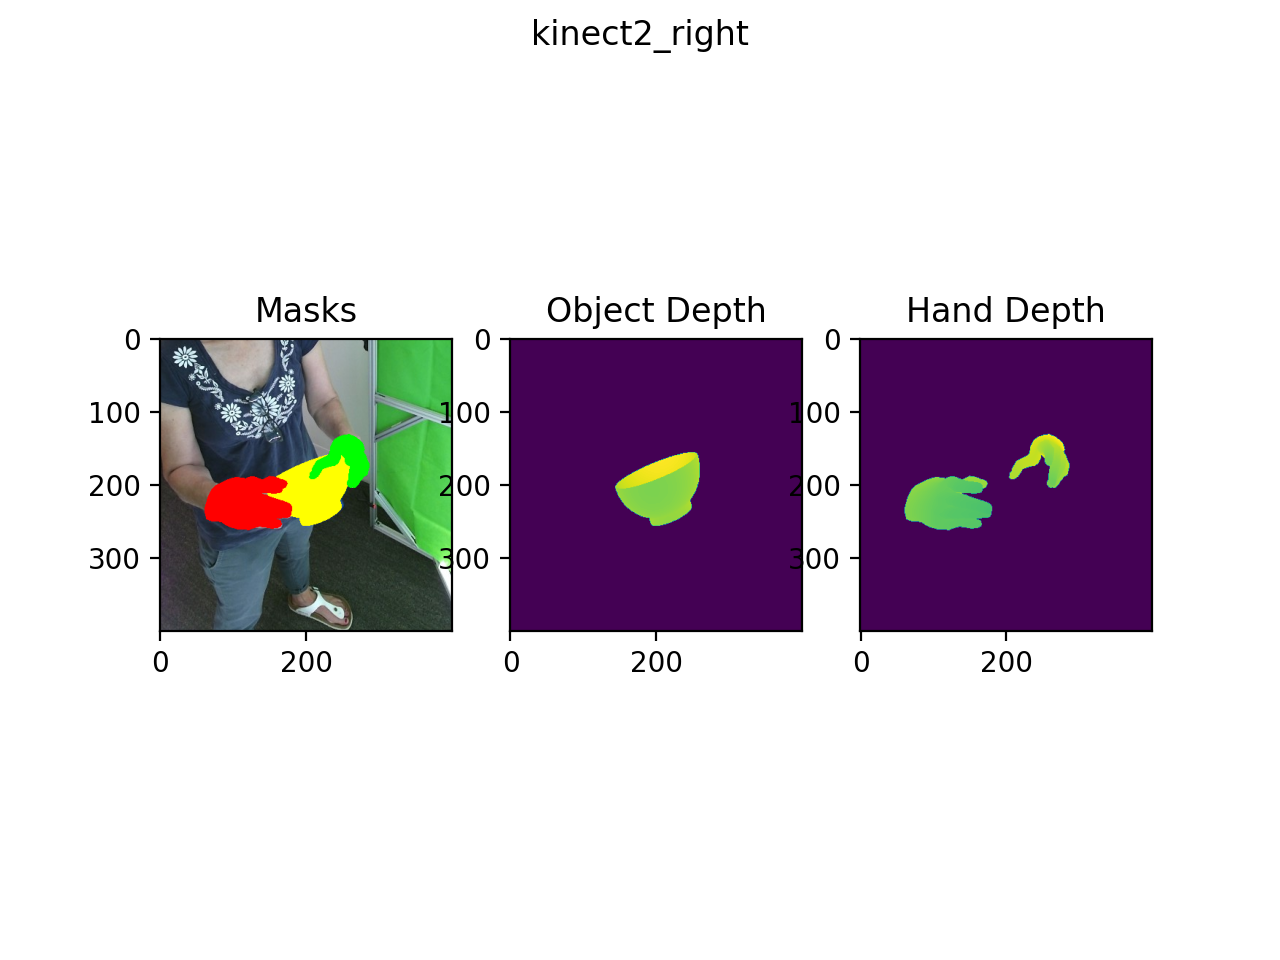

<IPython.core.display.Javascript object>


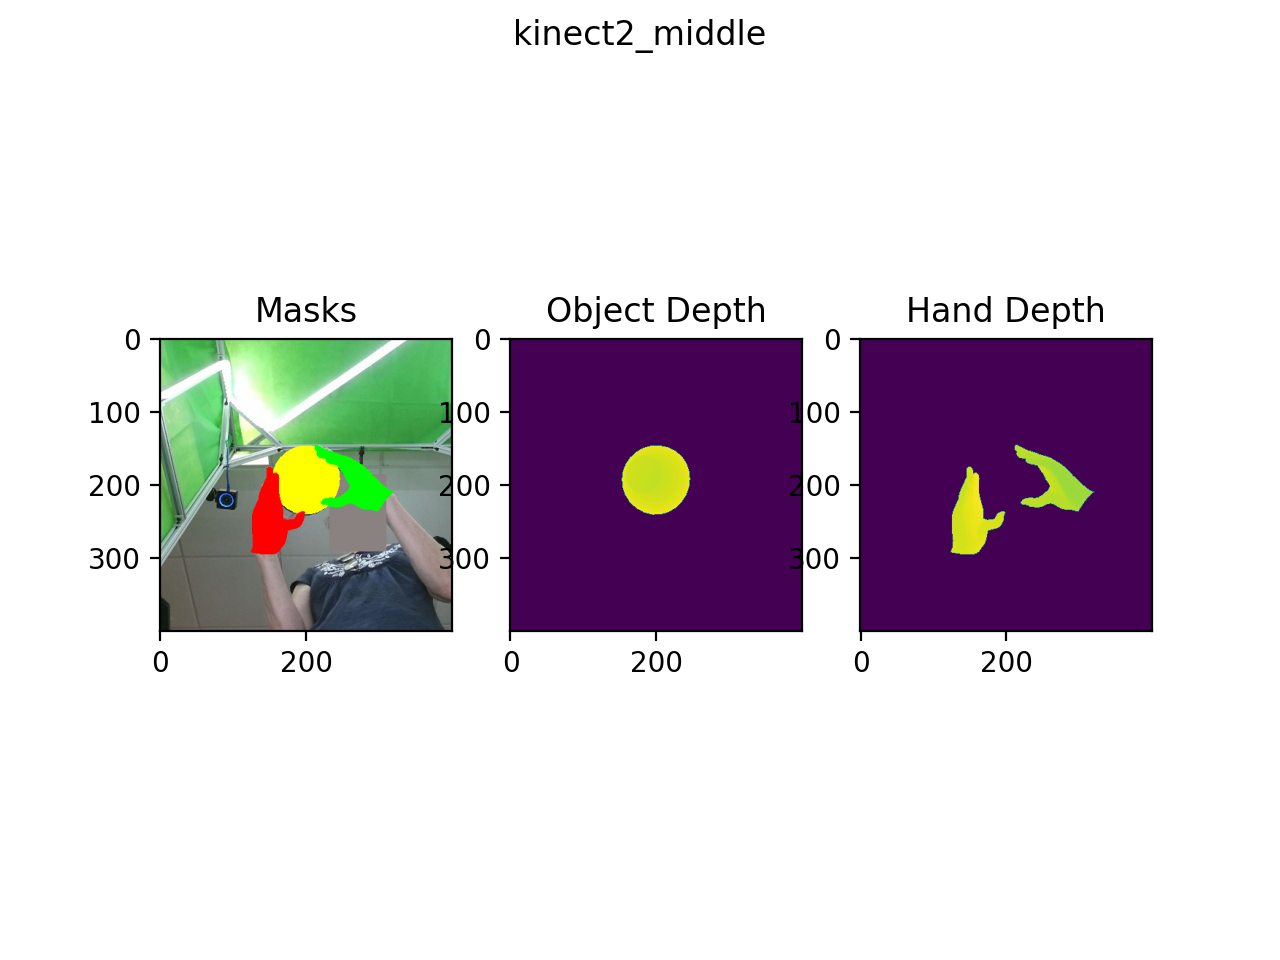

In [4]:
frame_idx = np.random.choice(len(cp))
crop_size = 400
plt.close('all')
for camera_name in ('kinect2_left', 'kinect2_right', 'kinect2_middle'):
    color_im = cv2.imread(cp.image_filenames('color', frame_idx)[camera_name])
    renderers = create_renderers(camera_name)
    show_rendering_output(renderers, color_im, camera_name, frame_idx, crop_size)
plt.show()